# 4장. 고객의 행동을 예측하는 테크닉
앞서 3장에서 스포츠센터 회원의 행동을 사전 분석하였다. 이제 이 데이터를 바탕으로, 머신러닝을 활용한 예측을 한다.  
회원의 행동은 이용 빈도 등에 따라 경향이 크게 달라진다.  
고객별 이용경향이 다르므로 고객을 특정 군집으로 나누는 클러스터링을 해보고, 이를 활용해 이용횟수를 예측하는 모델을 구축하자.

## Tech 31. 데이터를 읽어들이고 확인하자.

In [1]:
import pandas as pd
ul = pd.read_csv('3장/use_log.csv')
c = pd.read_csv('customer_join.csv')
ul.isnull().sum()

log_id         0
customer_id    0
usedate        0
dtype: int64

In [2]:
c.isnull().sum()

customer_id         0
name                0
class               0
gender              0
start_date          0
end_date         2842
campaign_id         0
is_deleted          0
class_name          0
price               0
campaign_name       0
mean                0
median              0
max                 0
min                 0
flag                0
cal_date            0
mem_period          0
dtype: int64

## Tech 32. 클러스터링으로 회원을 그룹화하자.
정해진 정답이 없기 때문에 비지도학습 클러스터링을 이용한다.

In [3]:
c.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,flag,cal_date,mem_period
0,OA832399,XXXX,C01,F,2015-05-01,NaN,CA1,0,0_종일,10500,2_일반,4.833333,5.0,8,2,1,2019-04-30,47
1,PL270116,XXXXX,C01,M,2015-05-01,NaN,CA1,0,0_종일,10500,2_일반,5.083333,5.0,7,3,1,2019-04-30,47
2,OA974876,XXXXX,C01,M,2015-05-01,NaN,CA1,0,0_종일,10500,2_일반,4.583333,5.0,6,3,1,2019-04-30,47
3,HD024127,XXXXX,C01,F,2015-05-01,NaN,CA1,0,0_종일,10500,2_일반,4.833333,4.5,7,2,1,2019-04-30,47
4,HD661448,XXXXX,C03,F,2015-05-01,NaN,CA1,0,2_야간,6000,2_일반,3.916667,4.0,6,1,1,2019-04-30,47


In [4]:
#c 데이터로 회원 그룹화를 진행한다. 여기서는 탈퇴 여부가 아닌, 이용이력을 중심으로 그룹화
#고객별 한달 이용 이력 데이터인 mean, median, max, min, mem_period(즉, 각 고객별 한달의 평균, 중위수, 최대, 최소 이용횟수 및 회원기간(단위: month))
cc = c[['mean', 'median', 'max', 'min', 'mem_period']]
cc.head()

,mean,median,max,min,mem_period
0,4.833333,5.0,8,2,47
1,5.083333,5.0,7,3,47
2,4.583333,5.0,6,3,47
3,4.833333,4.5,7,2,47
4,3.916667,4.0,6,1,47


In [5]:
#가장 전통적 방법인 k-means 클러스터링 실시

#<조건>
#1. 그룹 개수 설정: 4개
#2. mean~min은 월 이용 횟수와 관련한 변수이므로 1~8 사이값을 갖지만, mem_period는 이에 비해 값이 너무 크다.
#그러므로 mem_period에는 표준화를 하자.

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
#표준화
sc = StandardScaler()
cc_scaled = sc.fit_transform(cc)
pd.DataFrame(cc_scaled) #mean~min, mem_period 5개 변수가 표준화됨.

,0,1,2,3,4
0,-0.281206,-0.133676,0.081177,-0.533620,2.034025
1,-0.140545,-0.133676,-0.379928,-0.021149,2.034025
2,-0.421867,-0.133676,-0.841034,-0.021149,2.034025
3,-0.281206,-0.400393,-0.379928,-0.533620,2.034025
4,-0.796964,-0.667109,-0.841034,-1.046090,2.034025
...,...,...,...,...,...
4187,1.500501,1.466622,0.081177,2.541203,-1.288115
4188,2.625790,2.533488,1.003389,3.566144,-1.288115
4189,1.500501,1.466622,0.081177,2.541203,-1.288115
4190,3.188435,3.066921,1.464494,4.078615,-1.288115


In [6]:
#cc_scaled 데이터를 넣어 클러스터링
kmeans = KMeans(n_clusters=4, random_state=0)
clusters = kmeans.fit(cc_scaled)
clusters

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [7]:
#클러스터링 변수인 clusters 값을 원본 데이터인 'cc'내에 넣기 
cc['cluster'] = clusters.labels_
print(cc['cluster'].unique())
cc.head()

[3 1 0 2]


C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,mean,median,max,min,mem_period,cluster
0,4.833333,5.0,8,2,47,3
1,5.083333,5.0,7,3,47,3
2,4.583333,5.0,6,3,47,3
3,4.833333,4.5,7,2,47,3
4,3.916667,4.0,6,1,47,3


- 4개의 그룹으로 군집화 완료! (클러스터 넘버: 0, 1, 2, 3)
- 이제부터는 cc 데이터를 바탕으로, k-means 알고리즘이 자동적으로 군집화한 데이터를 분석해보자.

## Tech 33. 클러스터링 결과를 분석하자

In [8]:
#먼저 열 이름을 알아보기 쉽게 한글로 바꾼다.
cc.rename(columns = {'mean':'월평균값', 'median':'월중앙값', 'max':'월최댓값', 'min':'월최솟값', 'mem_period':'회원기간'}, inplace=True)
cc

C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,월평균값,월중앙값,월최댓값,월최솟값,회원기간,cluster
0,4.833333,5.0,8,2,47,3
1,5.083333,5.0,7,3,47,3
2,4.583333,5.0,6,3,47,3
3,4.833333,4.5,7,2,47,3
4,3.916667,4.0,6,1,47,3
...,...,...,...,...,...,...
4187,8.000000,8.0,8,8,1,2
4188,10.000000,10.0,10,10,1,2
4189,8.000000,8.0,8,8,1,2
4190,11.000000,11.0,11,11,1,2


In [9]:
#cluster를 기준으로 데이터 개수 세기
cc.groupby('cluster').count()

,월평균값,월중앙값,월최댓값,월최솟값,회원기간
cluster,,,,,
0,1334,1334,1334,1334,1334
1,763,763,763,763,763
2,846,846,846,846,846
3,1249,1249,1249,1249,1249


- 그룹 0에 해당하는 수가 1334개로 가장 많으며, 그 다음이 그룹3 > 그룹2 > 그룹1 순이다.

In [10]:
#그룹별 특징을 알아보자! -그룹별 평균값
cc.groupby('cluster').mean()

,월평균값,월중앙값,월최댓값,월최솟값,회원기간
cluster,,,,,
0,5.524239,5.375187,8.745877,2.687406,14.843328
1,3.054713,2.888598,4.756225,1.653997,9.263434
2,8.054608,8.039598,10.009456,6.160757,7.072104
3,4.677494,4.671337,7.232986,2.153723,36.915933


- 그룹2는 평균 회원기간은 가장 짧지만, 월 평균 이용횟수는 가장 높았다.
- 그룹1은 평균 회원기간도 짧고 월평균 이용횟수도 적은 그룹이다.
- 그룹0, 3은 평균 회원기간은 그룹1,2보다는 길다. 그런데 그룹3은 그룹0보다 회원기간은 길지만, 이용횟수는 더 적은 편이다.  
---
이렇듯, 그룹의 특징을 알면 그룹별로 다른 캠페인을 사용할 수 있다!  
여기선 변수가 딱 5개뿐이지만, 더 특징적인 변수를 포함시키면 보다 복잡한 클러스터링도 가능하다.  
아무튼 이 클러스터링 결과를 가시화해보자.

## Tech 34. 클러스터링 결과를 시각화하자.
2차원 그래프로 만들기 위해선 변수 2개가 필요한데, 지금은 변수가 5개이다.  
그래서 우선적으로, 5개 변수를 2개 변수(2개의 주성분)로 줄이는 차원 축소를 수행한다.(차원축소란? 정보를 되도록 잃지 않게 하면서 새로운 축을 만드는 것)  
차원축소의 대표적 방법인 주성분분석(PCA)를 수행하자.

In [11]:
from sklearn.decomposition import PCA
X = cc_scaled.copy()
#객체
pca = PCA(n_components=2)
#적용
pca.fit(X)
x_pca = pca.transform(X)
x_pca

array([[-0.81998232, -1.95909657],
       [-0.70792183, -1.79985685],
       [-1.06149902, -1.65982605],
       ...,
       [ 3.02793307,  1.13963534],
       [ 6.08311415,  0.58470806],
       [ 5.06472045,  0.76968382]])

In [12]:
#x_pca를 보기 쉽게 데이터프레임으로 만들기
pca_df = pd.DataFrame(x_pca)
pca_df['cluster'] = cc['cluster'] #앞서 표준화된 cc_scaled(변수5개)가 pca_df(주성분2개)로 바뀌었다. 몇번 클러스터인지 정보추가 
pca_df.head()

,0,1,cluster
0,-0.819982,-1.959097,3
1,-0.707922,-1.799857,3
2,-1.061499,-1.659826,3
3,-1.160764,-1.810139,3
4,-2.017132,-1.670101,3


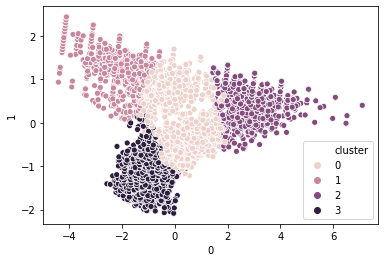

In [13]:
#이제 변수가 2개 생겼으니, 2차원 그래프를 그려보자. 'cluster'에 따라 색 바꿔서!
import matplotlib.pyplot as plt
import seaborn as sns
axs = plt.subplots()
axs = sns.scatterplot(0, 1, hue='cluster', data=pca_df)

In [14]:
sorted(pca_df['cluster'].unique()) #sort를 안하면 순서가 뒤죽박죽이라 정렬해줌 

[0, 1, 2, 3]

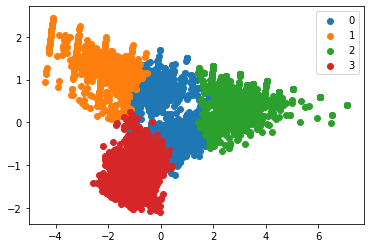

In [15]:
#또는 for문을 사용해 만들수도 있다.
for i in sorted(pca_df['cluster'].unique()):
    tmp = pca_df.loc[pca_df['cluster'] == i] #해당하는 클러스터 번호일 때 그림을 그리고, for문 실행하며 위에 덧그림 
    plt.scatter(tmp[0], tmp[1])
    plt.legend(sorted(pca_df['cluster'].unique()))

결과를 보면, 아주 깨끗하게 색깔이 나뉘어 있다. 정보를 보존한 채, 깔끔하게 데이터를 축소했음을 알 수 있다.(주성분의 개수를 적절치 않게 하면 겹치게 그래프가 그려진다.)  
이제 클러스터링 결과를 활용하여, 탈퇴 회원의 경향을 파악해보자.

## Tech 35. 클러스터링 결과를 바탕으로, 탈퇴 회원의 경향을 파악하자.
앞서 만든 클러스터 4개에서 지속회원과 탈퇴회원은 얼마나 있을까?

In [16]:
cc.head()

,월평균값,월중앙값,월최댓값,월최솟값,회원기간,cluster
0,4.833333,5.0,8,2,47,3
1,5.083333,5.0,7,3,47,3
2,4.583333,5.0,6,3,47,3
3,4.833333,4.5,7,2,47,3
4,3.916667,4.0,6,1,47,3


In [17]:
#앞서 만든 cc에서 지속/탈퇴회원 여부를 알아야 하므로 'is_deleted' 열을 추가한다. (이 열은 c 데이터에 있으므로 둘을 조인)
cc_join= pd.concat([cc, c], axis=1)
cc_join.head()

,월평균값,월중앙값,월최댓값,월최솟값,회원기간,cluster,customer_id,name,class,gender,...,class_name,price,campaign_name,mean,median,max,min,flag,cal_date,mem_period
0,4.833333,5.0,8,2,47,3,OA832399,XXXX,C01,F,...,0_종일,10500,2_일반,4.833333,5.0,8,2,1,2019-04-30,47
1,5.083333,5.0,7,3,47,3,PL270116,XXXXX,C01,M,...,0_종일,10500,2_일반,5.083333,5.0,7,3,1,2019-04-30,47
2,4.583333,5.0,6,3,47,3,OA974876,XXXXX,C01,M,...,0_종일,10500,2_일반,4.583333,5.0,6,3,1,2019-04-30,47
3,4.833333,4.5,7,2,47,3,HD024127,XXXXX,C01,F,...,0_종일,10500,2_일반,4.833333,4.5,7,2,1,2019-04-30,47
4,3.916667,4.0,6,1,47,3,HD661448,XXXXX,C03,F,...,2_야간,6000,2_일반,3.916667,4.0,6,1,1,2019-04-30,47


In [18]:
newdf = cc_join.groupby(['cluster','is_deleted'], as_index=False).count()[['cluster', 'is_deleted', 'customer_id']]
newdf

,cluster,is_deleted,customer_id
0,0,0,785
1,0,1,549
2,1,1,763
3,2,0,827
4,2,1,19
5,3,0,1230
6,3,1,19


In [19]:
#위의 newdf에서 cluster별 탈퇴 및 미탈퇴회원 비율을 for문으로 뽑아보자.
de0 = (newdf['is_deleted']==0) #지속회원
de1 = (newdf['is_deleted']==1) #탈퇴회원

for i in range(0, 4):
    tmp = (newdf['cluster']==i)
    print('Cluster '+ str(i) + '의 탈퇴회원 비율은 ' + str(round((newdf.loc[(tmp & de1),  'customer_id'].sum() / newdf.loc[tmp, 'customer_id'].sum())*100, 2)) + '%')
    print('Cluster '+ str(i) + '의 지속회원 비율은 ' + str(round((newdf.loc[(tmp & de0),  'customer_id'].sum() / newdf.loc[tmp, 'customer_id'].sum())*100, 2)) + '%')
    print(' ')

Cluster 0의 탈퇴회원 비율은 41.15%
Cluster 0의 지속회원 비율은 58.85%
 
Cluster 1의 탈퇴회원 비율은 100.0%
Cluster 1의 지속회원 비율은 0.0%
 
Cluster 2의 탈퇴회원 비율은 2.25%
Cluster 2의 지속회원 비율은 97.75%
 
Cluster 3의 탈퇴회원 비율은 1.52%
Cluster 3의 지속회원 비율은 98.48%
 


위의 결과를 보면, 클러스터별로 탈퇴회원과 지속회원의 수를 알아볼 수 있다.  

- 클러스터 1: 탈퇴회원만 존재함
- 클러스터 2, 3: 지속회원>> 탈퇴회원
- 클러스터 0: 지속회원과 탈퇴회원 수 비슷

---

앞서, 
- 그룹2는 평균 회원기간은 가장 짧지만, 월 평균 이용횟수는 가장 높았다.
- 그룹1은 평균 회원기간도 짧고 월평균 이용횟수도 적은 그룹이다.
- 그룹0, 3은 평균 회원기간은 그룹1,2보다는 길다. 그런데 그룹3은 그룹0보다 회원기간은 길지만, 이용횟수는 더 적은 편이다.

였음을 참고하면, 그룹1은 가장 안좋은 그룹(가장 짧게 이용하고 모두 탈퇴함),  
그룹2는 초반에 불타오르는 좋은 그룹(이용횟수가 많고 지속회원이 많음. 그런데 평균 회원기간이 짧아서 초기에 의욕적으로 이용하는 듯),  
그룹3은 안정적인 그룹(회원기간이 길고, 이용횟수는 적으나 지속회원이 많음),  
그룹0는 회원기간이 길고 탈퇴회원 지속회원 비등비등한 그룹이다.

In [20]:
#이번엔 정기적/비정기적 이용여부(flag 컬럼)를 살펴본다.
newdf2 = cc_join.groupby(['cluster','flag'], as_index=False).count()[['cluster', 'flag', 'customer_id']]
newdf2

,cluster,flag,customer_id
0,0,0,228
1,0,1,1106
2,1,0,497
3,1,1,266
4,2,0,52
5,2,1,794
6,3,0,2
7,3,1,1247


In [21]:
#마찬가지로 for문으로 비율을 자동출력해보자.
flag0 = (newdf2['flag']==0) #비정기회원
flag1 = (newdf2['flag']==1) #정기회원

for i in range(0, 4):
    tmp = (newdf2['cluster']==i)
    print('Cluster '+ str(i) + '의 정기회원 비율은 ' + str(round((newdf2.loc[(tmp & flag1),  'customer_id'].sum() / newdf2.loc[tmp, 'customer_id'].sum())*100, 2)) + '%')
    print('Cluster '+ str(i) + '의 비정기회원 비율은 ' + str(round((newdf2.loc[(tmp & flag0),  'customer_id'].sum() / newdf2.loc[tmp, 'customer_id'].sum())*100, 2)) + '%')
    print(' ')

Cluster 0의 정기회원 비율은 82.91%
Cluster 0의 비정기회원 비율은 17.09%
 
Cluster 1의 정기회원 비율은 34.86%
Cluster 1의 비정기회원 비율은 65.14%
 
Cluster 2의 정기회원 비율은 93.85%
Cluster 2의 비정기회원 비율은 6.15%
 
Cluster 3의 정기회원 비율은 99.84%
Cluster 3의 비정기회원 비율은 0.16%
 


flag는 1이면 정기적이용, 0이면 비정기적 이용이다.  

- 그룹1은 가장 이용을 적게하는 그룹-> 역시 flag가 0인게 훨씬 많다. (비정기 65 > 정기 35%)
- 그룹2는 초반에 불타오르는 좋은그룹 -> flag가 1인게 월등히 많다. (정기 93 > 비정기 6%)
- 그룹3은 안정적 이용그룹 -> flag가 1인게 그룹2보다도 월등히 많다. (정기 99 > 비정기 0.1%)
- 그룹0은 지속,탈퇴 비등한 그룹 -> flag가 1인게 조금 더 많다. (정기 83 > 비정기 17%)

---
정리하면, 그룹0,3은 회원기간이 길며 안정적 이용 / 그룹2는 초반 불타오르는 그룹 / 그룹1은 이용을 잘 안하는 그룹 으로 분류가능.  

이제는  "이용 횟수"를 예측하는 모델을 만들어보자.  
**지금까지의 분석을 통해, 회원의 이용 방법(행동)이 중요함을 알 수 있었다. 과거의 고객 행동 데이터로부터, 다음 달 이용횟수 예측을 해보자!**

## Tech 36. 다음달의 이용횟수 예측을 위해 데이터를 준비하자.
지도학습 (회귀) 모델 사용: 정답 데이터로 학습을 시켜야함. 과거 6개월의 데이터를 바탕으로 다음 달 이용횟수를 예측한다.

In [22]:
#먼저 ul 데이터로 연월, 회원별로 집계
ul.head()

,log_id,customer_id,usedate
0,L00000049012330,AS009373,2018-04-01
1,L00000049012331,AS015315,2018-04-01
2,L00000049012332,AS040841,2018-04-01
3,L00000049012333,AS046594,2018-04-01
4,L00000049012334,AS073285,2018-04-01


In [23]:
#datetime 형태로 변경
ul['usedate'] = pd.to_datetime(ul['usedate'])
#usedate -> 연월로 변경
ul['연월'] = ul['usedate'].dt.strftime('%Y-%m')
ul.head()

,log_id,customer_id,usedate,연월
0,L00000049012330,AS009373,2018-04-01,2018-04
1,L00000049012331,AS015315,2018-04-01,2018-04
2,L00000049012332,AS040841,2018-04-01,2018-04
3,L00000049012333,AS046594,2018-04-01,2018-04
4,L00000049012334,AS073285,2018-04-01,2018-04


In [24]:
#이제 연월, 고객id 별로 이용횟수를 집계해보자
ul_m = ul.groupby(['연월', 'customer_id'], as_index=False).count()

#새로운 데이터 ul_m
ul_m.head()

,연월,customer_id,log_id,usedate
0,2018-04,AS002855,4,4
1,2018-04,AS009013,2,2
2,2018-04,AS009373,3,3
3,2018-04,AS015315,6,6
4,2018-04,AS015739,7,7


In [25]:
#log_id -> cnt 컬럼명 변경
ul_m.rename(columns = {'log_id': 'cnt'}, inplace=True)
#usedate는 필요없으므로 버림
del ul_m['usedate']

ul_m

,연월,customer_id,cnt
0,2018-04,AS002855,4
1,2018-04,AS009013,2
2,2018-04,AS009373,3
3,2018-04,AS015315,6
4,2018-04,AS015739,7
...,...,...,...
36837,2019-03,TS995853,8
36838,2019-03,TS998593,8
36839,2019-03,TS999079,3
36840,2019-03,TS999231,6


In [26]:
#이제 연월, 고객별 이용횟수를 카운트한 ul_m 데이터가 만들어졌다!
## 이제부터는 2018.10 ~ 2019.03(6개월 간의 과거 데이터)의 이용 횟수를 저장해, 2019.04 의 이용횟수를 예측해보자.
    ## 이를 위해, 과거 데이터 한달에 대응하는 과거 6개월분의 데이터를 활용해 예측한다.
        #(예를 들어, 2018년 10월은 -> 2018년 4월~2018년 9월까지의 6개월분 데이터를 예측해서 정답(2018년 10월)과 맞춰봄)
        #이런식으로 2018년 10월, 2018-11월, ... , 2019년 3월까지 한다. 
        #그럼 2019년 4월은? -> 과거 데이터 2018년 11월 ~ 2019년 3월(6개월분)으로 예측하면 되겠지?

In [27]:
#ul_m 데이터는 다음 5장에서도 또 이용할 데이터이므로 미리 저장해둔다.
ul_m.to_csv('use_log_months.csv', index=False)

In [28]:
year_months = list(ul_m['연월'].unique())
pred_data = pd.DataFrame()

year_months

['2018-04',
 '2018-05',
 '2018-06',
 '2018-07',
 '2018-08',
 '2018-09',
 '2018-10',
 '2018-11',
 '2018-12',
 '2019-01',
 '2019-02',
 '2019-03']

In [29]:
ul_m.head()

,연월,customer_id,cnt
0,2018-04,AS002855,4
1,2018-04,AS009013,2
2,2018-04,AS009373,3
3,2018-04,AS015315,6
4,2018-04,AS015739,7


In [30]:
#year_month의 2018-10부터 뽑아야 하므로 6부터 끝까지 뽑는다.
for i in range(6, len(year_months)):
    #해당월인 거 하나씩 뽑아 임시 데이터프레임 tmp에 저장
    tmp = ul_m.loc[ul_m['연월'] == year_months[i]]
    #tmp의 cnt를 cnt_pred로 변경 (얘가 예측하려고 하는 정답 데이터)
    tmp.rename(columns = {'cnt': 'cnt_pred'}, inplace=True)
    
    #그리고 여기서는 tmp 하나의 달에 대응하는 그 이전 6개월달 분의 데이터(tmp_before)를 만든다.
    for j in range(1,7):
        tmp_before = ul_m.loc[ul_m['연월'] == year_months[i-j]]
        del tmp_before['연월']
        
        #tmp_before에는 cnt 열을 과거의 열로 하나씩 채워나감.
        #예를 들어 2018년 10월에 대응하는 tmp_before는 2018.04 ~ 2018.09이다. 2018년 9월부터 역순으로 cnt 0 , cnt 1, .. cnt 6 이라는 열이 생성됨 
        tmp_before.rename(columns = {'cnt': 'cnt_{}'.format(j-1)}, inplace=True)
        
        #그리고 tmp와 tmp_before를 결합 
        tmp = pd.merge(tmp, tmp_before, on ='customer_id', how='left')
        
    #이렇게 tmp_before를 전부 뽑아 tmp로 결합하고 나서는, 비워뒀던 pred_data 에 tmp를 하나씩 결합시킨다. axis=0이므로 row-bind임 
    pred_data = pd.concat([pred_data, tmp], ignore_index = True)
    
pred_data

C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,연월,customer_id,cnt_pred,cnt_0,cnt_1,cnt_2,cnt_3,cnt_4,cnt_5
0,2018-10,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,2018-10,AS008805,2,2.0,5.0,7.0,8.0,NaN,NaN
2,2018-10,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
3,2018-10,AS015233,7,9.0,11.0,5.0,7.0,7.0,NaN
4,2018-10,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0
...,...,...,...,...,...,...,...,...,...
18305,2019-03,TS995853,8,11.0,NaN,NaN,NaN,NaN,NaN
18306,2019-03,TS998593,8,7.0,8.0,7.0,9.0,9.0,9.0
18307,2019-03,TS999079,3,2.0,6.0,9.0,6.0,6.0,4.0
18308,2019-03,TS999231,6,6.0,3.0,8.0,5.0,5.0,4.0


- 이렇게 2018년 10월 데이터 촤르륵~ 있고 그 밑은 2018년 11월꺼, ... 이런 식으로 2019년 3월것까지 완성되었다.
- 보면 `cnt_0 ~ cnt_5`가 학습에 사용할 독립변수, 그리고 `cnt_pred`가 학습에 사용할 종속변수이다. 고객별로 지난 6개월간 한달동안 몇회 이용했는지가 해당 달에 이용한 횟수에 영향을 미칠 것이라고 생각하고 데이터셋을 구성하였다. 
- 데이터셋 중에서 NaN의 경우는 가입기간이 짧아 해당 기간에 헬스장을 이용하지 않은 사람이기 때문이다.
    - 이렇게 학습을 마치고 난 뒤에는 2019-04에 대해 예측할 것이다.

In [31]:
#NaN이 있는 경우는 제대로 예측하지 못하므로 NaN이 1개라도 포함되면 그 행을 전체 삭제한다.
pred_data = pred_data.dropna() #디폴트는 how='any', axis= 0 (NaN이 1개라도 포함된 경우 행 전체 삭제)
pred_data

,연월,customer_id,cnt_pred,cnt_0,cnt_1,cnt_2,cnt_3,cnt_4,cnt_5
0,2018-10,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
2,2018-10,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
4,2018-10,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0
5,2018-10,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0
7,2018-10,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0
...,...,...,...,...,...,...,...,...,...
18304,2019-03,TS995299,3,3.0,5.0,4.0,5.0,4.0,5.0
18306,2019-03,TS998593,8,7.0,8.0,7.0,9.0,9.0,9.0
18307,2019-03,TS999079,3,2.0,6.0,9.0,6.0,6.0,4.0
18308,2019-03,TS999231,6,6.0,3.0,8.0,5.0,5.0,4.0


In [32]:
#인덱스가 바뀌어있지 않으므로 초기화
pred_data = pred_data.reset_index(drop=True) #이전의 인덱스 버림
pred_data.head()

,연월,customer_id,cnt_pred,cnt_0,cnt_1,cnt_2,cnt_3,cnt_4,cnt_5
0,2018-10,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,2018-10,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
2,2018-10,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0
3,2018-10,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0
4,2018-10,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0


## Tech 37. 특징이 되는 변수를 추가하자
pred_data를 잘 만들었지만, 그냥 변수 cnt_0~cnt_5을 갖고 cnt_pred를 예측하기엔 변수의 수가 좀 적다.  
예측의 성능을 높이기 위해서는 데이터를 잘 설명하는 좋은 변수가 추가될수록 성능이 높아진다. 다른 변수들을 추가해보자.

In [33]:
#여기서는 '회원 기간'를 추가해보자. 
#(이유: 회원 기간은 시계열 변화를 볼 수 있기 때문. pred_data의 경우도 시계열 데이터이므로 의미있음)
c.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,flag,cal_date,mem_period
0,OA832399,XXXX,C01,F,2015-05-01,NaN,CA1,0,0_종일,10500,2_일반,4.833333,5.0,8,2,1,2019-04-30,47
1,PL270116,XXXXX,C01,M,2015-05-01,NaN,CA1,0,0_종일,10500,2_일반,5.083333,5.0,7,3,1,2019-04-30,47
2,OA974876,XXXXX,C01,M,2015-05-01,NaN,CA1,0,0_종일,10500,2_일반,4.583333,5.0,6,3,1,2019-04-30,47
3,HD024127,XXXXX,C01,F,2015-05-01,NaN,CA1,0,0_종일,10500,2_일반,4.833333,4.5,7,2,1,2019-04-30,47
4,HD661448,XXXXX,C03,F,2015-05-01,NaN,CA1,0,2_야간,6000,2_일반,3.916667,4.0,6,1,1,2019-04-30,47


In [34]:
#앞의 c 데이터의 start_date를 pred_data에 결합한다. 공통컬럼 customer_id를 이용
## 여기서 회원기간(mem_period)가 아닌 start_date를 추가하는 이유는 무엇일까?? -> mem_period는 우리가 3장에서 임의로 만들었던 것이기 때문이다. 
        #그때는 탈퇴회원이 별로 없음을 감안해 탈퇴를 안 한 경우 임의로 2019-04-30 에서 start_date(가입일자)를 빼서 구했다.
    #하지만 여기서는 '연월' 이라는 구분자가 있으므로, 해당 연월에 가입일자를 뺀 회원 기간을 만들 수 있다!
    
pred_data = pd.merge(pred_data, c[['customer_id', 'start_date']], on = 'customer_id', how='left')
pred_data.head()

,연월,customer_id,cnt_pred,cnt_0,cnt_1,cnt_2,cnt_3,cnt_4,cnt_5,start_date
0,2018-10,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01
1,2018-10,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01
2,2018-10,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01
3,2018-10,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01
4,2018-10,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01


In [35]:
pred_data.dtypes

연월              object
customer_id     object
cnt_pred         int64
cnt_0          float64
cnt_1          float64
cnt_2          float64
cnt_3          float64
cnt_4          float64
cnt_5          float64
start_date      object
dtype: object

In [36]:
#연월을 now_date로 바꾸자.

#먼저 datetime 형태로 변경
pred_data['now_date'] = pd.to_datetime(pred_data['연월'], format="%Y-%m-%d")
#start_date도 datetime으로 바꿔주기
pred_data['start_date'] = pd.to_datetime(pred_data['start_date'])

pred_data.head()

,연월,customer_id,cnt_pred,cnt_0,cnt_1,cnt_2,cnt_3,cnt_4,cnt_5,start_date,now_date
0,2018-10,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01,2018-10-01
1,2018-10,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01,2018-10-01
2,2018-10,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01,2018-10-01
3,2018-10,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01,2018-10-01
4,2018-10,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01,2018-10-01


In [37]:
pred_data.dtypes

연월                     object
customer_id            object
cnt_pred                int64
cnt_0                 float64
cnt_1                 float64
cnt_2                 float64
cnt_3                 float64
cnt_4                 float64
cnt_5                 float64
start_date     datetime64[ns]
now_date       datetime64[ns]
dtype: object

In [38]:
#이제 start_date, now_date 둘 다 datetime 형태이므로 날짜 연산이 가능하다. 두 날짜의 차이를 계산한 새로운 'period'(단위: month) 열을 만들자.
from dateutil.relativedelta import relativedelta
pred_data['period'] = None #초기화

for i in range(len(pred_data)):
    delta = relativedelta(pred_data['now_date'][i], pred_data['start_date'][i])
    pred_data['period'][i] = delta.years*12 + delta.months
    
pred_data.head()

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,연월,customer_id,cnt_pred,cnt_0,cnt_1,cnt_2,cnt_3,cnt_4,cnt_5,start_date,now_date,period
0,2018-10,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01,2018-10-01,23
1,2018-10,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01,2018-10-01,35
2,2018-10,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01,2018-10-01,39
3,2018-10,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01,2018-10-01,16
4,2018-10,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01,2018-10-01,12


In [39]:
#인덱싱은 요렇게 해도 같은 결과임(loc 사용) -> 근데 위의 방법이 시간은 더 적게 걸리는듯 
from dateutil.relativedelta import relativedelta
pred_data['period'] = None #초기화

for i in range(len(pred_data)):
    delta = relativedelta(pred_data.loc[i, 'now_date'], pred_data.loc[i, 'start_date'])
    pred_data.loc[i, 'period'] = delta.years*12 + delta.months
    
pred_data.head()

,연월,customer_id,cnt_pred,cnt_0,cnt_1,cnt_2,cnt_3,cnt_4,cnt_5,start_date,now_date,period
0,2018-10,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01,2018-10-01,23
1,2018-10,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01,2018-10-01,35
2,2018-10,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01,2018-10-01,39
3,2018-10,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01,2018-10-01,16
4,2018-10,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01,2018-10-01,12


## Tech 38. 모델 구축
이제 드디어 모델을 구축하자. 여기서 사용할 모델은 가장 기본적인 모델인 선형 회귀(linear regression)이다.

In [40]:
# 다만 가입한 일자(start_date)가 2018년 4월 이후인 데이터만 따로 뽑아 데이터를 만든다. 
#오래전부터 있던 회원은 가입 시기 데이터가 존재하지 않거나 이용 횟수가 안정적일 가능성이 있기 때문! 
print(pred_data.shape)
pred_data = pred_data.loc[pred_data['start_date'] >= pd.to_datetime('20180401')]
pred_data.reset_index(inplace=True, drop=True) #인덱스 삭제
print(pred_data.shape)

(15113, 12)
(1702, 12)


In [41]:
pred_data.head()

,연월,customer_id,cnt_pred,cnt_0,cnt_1,cnt_2,cnt_3,cnt_4,cnt_5,start_date,now_date,period
0,2018-10,AS185951,1,5.0,3.0,3.0,7.0,3.0,10.0,2018-04-09,2018-10-01,5
1,2018-10,AS197200,12,6.0,8.0,9.0,6.0,8.0,8.0,2018-04-15,2018-10-01,5
2,2018-10,AS200286,3,6.0,3.0,6.0,6.0,7.0,10.0,2018-04-06,2018-10-01,5
3,2018-10,AS251169,2,4.0,6.0,5.0,8.0,10.0,7.0,2018-04-03,2018-10-01,5
4,2018-10,AS345469,1,3.0,5.0,6.0,5.0,4.0,7.0,2018-04-12,2018-10-01,5


In [42]:
#선형회귀 모델 적용
from sklearn import linear_model as lm
import sklearn.model_selection

model = lm.LinearRegression()

In [43]:
#학습할 독립변수
X = pred_data[['cnt_0', 'cnt_1', 'cnt_2', 'cnt_3', 'cnt_4', 'cnt_5', 'period']]
#학습할 종속변수
y = pred_data['cnt_pred']

#학습: 먼저 train/ test set으로 나눔 (여기서 test set은 validation set을 의미함- 모두 학습에 사용할 거니까)
## 디폴트로는 train: test 75%: 25% 로 분할됨 
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y)
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [44]:
#검증
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.6099994670376752
0.600120656932531


train set에 대해서는 61%의 정확도가, validation set으로 검증해보니 58%의 정확도가 나옴.  
매우 기본적인 모델이기에 약 60%의 정확도가 나왔는데, 변수를 바꾸거나 train/test split 비율을 바꾸거나, 다른 모델을 쓰면 정확도가 바뀔 수 있음.  

---
사실 정확도가 높은 예측 모델을 만들었다 할지라도, 이 모델에 대해 제대로 이해하지 못하면 현장에서 도입할 때 설명할 수가 없다.  
그렇기 때문에 정확도가 높은 블랙박스 모델보다는 정확도가 낮아도 설명이 가능한 모델이 사용되는 경우가 많다.(그래서 이런 선형 회귀 모델도 간단해서 굉장히 자주 쓰이는 모델임)

## Tech 39. 모델에 기여하는 변수를 확인하자 

In [45]:
model.coef_ #얘를 출력하면 독립변수별 기여도(coefficient)를 확인할 수 있다.

array([0.31371769, 0.20488838, 0.16696374, 0.20407957, 0.08713085,
       0.06321151, 0.05679209])

In [46]:
#가독성을 높이기 위해 데이터프레임 형태로 만들어보자
coef = pd.DataFrame({'feature_names': X.columns, 'coefficient': model.coef_})
coef

,feature_names,coefficient
0,cnt_0,0.313718
1,cnt_1,0.204888
2,cnt_2,0.166964
3,cnt_3,0.204080
4,cnt_4,0.087131
5,cnt_5,0.063212
6,period,0.056792


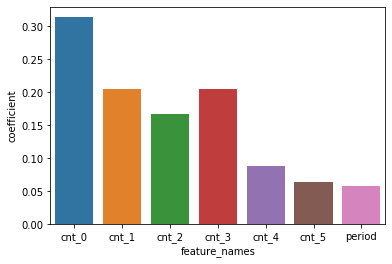

In [47]:
#더 가독성을 높이기 위해 그래프로 나타내보자
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.barplot('feature_names', 'coefficient', data=coef) 

결과를 보니, cnt_0가 가장 영향력이 크며, 더욱 과거로 갈수록(cnt0 -> cnt5) 기여도가 낮아진다.  
즉, **이전 달의 이용횟수가 다음달의 이용횟수에 가장 큰 영향을 미친다.** -> 이는 직감적으로도 이해하기 쉬운 이야기이다.

## Tech 40. 다음 달의 이용 횟수를 예측하자

In [48]:
#임의로 회원 2명의 이용데이터를 input으로 넣었을 때의 이용 횟수를 예측해보자.
x1 = [3, 4, 4, 6, 8, 7, 8]
x2 = [2, 2, 3, 3, 4, 6, 8]
x_pred = [x1, x2]

In [49]:
#x_pred에 대해 모델을 적용해 예측해보면?
model.predict(x_pred)

array([3.8415685, 1.9271367])

회원 1은 다음 달 3.84회, 회원2는 1.98회를 이용할 것임을 예측할 수 있다.  
여기서 더 나아가서, 교재에는 없지만 2019년 4월의 이용 횟수를 예측해보자.

In [61]:
#이번엔 딱 2019년 4월에 대한 것이므로 그 이전인 2018년 10월~ 2019년 3월의 데이터를 담아보자.
i =12
j = 1

tmp = ul_m.loc[ul_m['연월'] == year_months[i-j]]
del tmp['연월']
tmp.rename(columns  = {'cnt': 'cnt_{}'.format(j-1)}, inplace=True)
tmp.reset_index(inplace=True, drop=True)
tmp

C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,customer_id,cnt_0
0,AS002855,4
1,AS008805,1
2,AS009373,5
3,AS015233,8
4,AS015315,4
...,...,...
2948,TS995853,8
2949,TS998593,8
2950,TS999079,3
2951,TS999231,6


In [62]:
i = 12
for j in range(2, 7):
    tmp_before = ul_m.loc[ul_m['연월'] == year_months[i-j]]
    del tmp_before['연월']
    tmp_before.rename(columns  = {'cnt': 'cnt_{}'.format(j-1)}, inplace=True)
    tmp = pd.merge(tmp, tmp_before, on ='customer_id', how='left')
    
tmp

C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,customer_id,cnt_0,cnt_1,cnt_2,cnt_3,cnt_4,cnt_5
0,AS002855,4,5.0,6.0,2.0,5.0,3.0
1,AS008805,1,6.0,1.0,5.0,3.0,2.0
2,AS009373,5,6.0,7.0,4.0,4.0,5.0
3,AS015233,8,4.0,9.0,9.0,7.0,7.0
4,AS015315,4,5.0,5.0,5.0,7.0,4.0
...,...,...,...,...,...,...,...
2948,TS995853,8,11.0,NaN,NaN,NaN,NaN
2949,TS998593,8,7.0,8.0,7.0,9.0,9.0
2950,TS999079,3,2.0,6.0,9.0,6.0,6.0
2951,TS999231,6,6.0,3.0,8.0,5.0,5.0


이렇게 해서 2019년 3월 ~ 2018년 10월의 **tmp** 데이터가 만들어졌다. (연월을 확인하고 싶다면 del~ 부분 코드를 주석처리하고 실행)  
아까 했던 대로 tmp 의 데이터를 전처리해보자.

In [63]:
#하나라도 NaN이 있다면 삭제
tmp = tmp.dropna()
print(tmp.shape)

(2537, 7)


In [64]:
#c 데이터를 함께 조인하여 가입일자를 가져온다
tmp = pd.merge(tmp, c[['customer_id', 'start_date']], on = 'customer_id', how='left')
tmp.head()

,customer_id,cnt_0,cnt_1,cnt_2,cnt_3,cnt_4,cnt_5,start_date
0,AS002855,4,5.0,6.0,2.0,5.0,3.0,2016-11-01
1,AS008805,1,6.0,1.0,5.0,3.0,2.0,2018-06-07
2,AS009373,5,6.0,7.0,4.0,4.0,5.0,2015-11-01
3,AS015233,8,4.0,9.0,9.0,7.0,7.0,2018-05-13
4,AS015315,4,5.0,5.0,5.0,7.0,4.0,2015-07-01


In [65]:
#start_date를 datetime으로
tmp['start_date'] = pd.to_datetime(tmp['start_date'])
tmp.dtypes

customer_id            object
cnt_0                   int64
cnt_1                 float64
cnt_2                 float64
cnt_3                 float64
cnt_4                 float64
cnt_5                 float64
start_date     datetime64[ns]
dtype: object

In [66]:
#가입일자가 2018년 4월 이후인 애들만 뽑음 -> 399개로 줄어듦 
print(tmp.shape)
tmp = tmp.loc[tmp['start_date'] >= pd.to_datetime('20180401')]
tmp.reset_index(inplace=True, drop=True) #인덱스 삭제
print(tmp.shape)

(2537, 8)
(399, 8)


In [67]:
tmp

,customer_id,cnt_0,cnt_1,cnt_2,cnt_3,cnt_4,cnt_5,start_date
0,AS008805,1,6.0,1.0,5.0,3.0,2.0,2018-06-07
1,AS015233,8,4.0,9.0,9.0,7.0,7.0,2018-05-13
2,AS093634,9,8.0,7.0,7.0,8.0,10.0,2018-10-07
3,AS100947,3,5.0,9.0,8.0,8.0,9.0,2018-05-12
4,AS115629,1,4.0,4.0,1.0,3.0,4.0,2018-07-04
...,...,...,...,...,...,...,...,...
394,TS977703,7,8.0,6.0,7.0,5.0,8.0,2018-04-15
395,TS978415,7,10.0,7.0,6.0,10.0,8.0,2018-07-06
396,TS979550,9,7.0,8.0,10.0,7.0,7.0,2018-10-08
397,TS985617,10,10.0,10.0,9.0,8.0,8.0,2018-09-12


In [68]:
#이 데이터는 2019년 4월을 기준으로 한, 그 이전 6개월의 데이터(2019.03~2018.10)이다.
#기준연월 2019년 4월 기준, 가입일자 간의 month 차이를 계산해 period 열에 추가한다.
tmp['now_date'] = pd.to_datetime('20190401')
print(tmp.dtypes)
tmp

customer_id            object
cnt_0                   int64
cnt_1                 float64
cnt_2                 float64
cnt_3                 float64
cnt_4                 float64
cnt_5                 float64
start_date     datetime64[ns]
now_date       datetime64[ns]
dtype: object


,customer_id,cnt_0,cnt_1,cnt_2,cnt_3,cnt_4,cnt_5,start_date,now_date
0,AS008805,1,6.0,1.0,5.0,3.0,2.0,2018-06-07,2019-04-01
1,AS015233,8,4.0,9.0,9.0,7.0,7.0,2018-05-13,2019-04-01
2,AS093634,9,8.0,7.0,7.0,8.0,10.0,2018-10-07,2019-04-01
3,AS100947,3,5.0,9.0,8.0,8.0,9.0,2018-05-12,2019-04-01
4,AS115629,1,4.0,4.0,1.0,3.0,4.0,2018-07-04,2019-04-01
...,...,...,...,...,...,...,...,...,...
394,TS977703,7,8.0,6.0,7.0,5.0,8.0,2018-04-15,2019-04-01
395,TS978415,7,10.0,7.0,6.0,10.0,8.0,2018-07-06,2019-04-01
396,TS979550,9,7.0,8.0,10.0,7.0,7.0,2018-10-08,2019-04-01
397,TS985617,10,10.0,10.0,9.0,8.0,8.0,2018-09-12,2019-04-01


In [69]:
from dateutil.relativedelta import relativedelta
tmp['period'] = None #초기화

for i in range(len(tmp)):
    delta = relativedelta(tmp.loc[i, 'now_date'], tmp.loc[i, 'start_date'])
    tmp.loc[i, 'period'] = delta.years*12 + delta.months
    
tmp.head()

,customer_id,cnt_0,cnt_1,cnt_2,cnt_3,cnt_4,cnt_5,start_date,now_date,period
0,AS008805,1,6.0,1.0,5.0,3.0,2.0,2018-06-07,2019-04-01,9
1,AS015233,8,4.0,9.0,9.0,7.0,7.0,2018-05-13,2019-04-01,10
2,AS093634,9,8.0,7.0,7.0,8.0,10.0,2018-10-07,2019-04-01,5
3,AS100947,3,5.0,9.0,8.0,8.0,9.0,2018-05-12,2019-04-01,10
4,AS115629,1,4.0,4.0,1.0,3.0,4.0,2018-07-04,2019-04-01,8


In [70]:
tmp.isnull().sum()

customer_id    0
cnt_0          0
cnt_1          0
cnt_2          0
cnt_3          0
cnt_4          0
cnt_5          0
start_date     0
now_date       0
period         0
dtype: int64

In [71]:
#이제 필요한 열만 걸러낸다.
tmp_pred = tmp[['cnt_0', 'cnt_1', 'cnt_2', 'cnt_3', 'cnt_4', 'cnt_5', 'period']]
#모델에 대해 예측한 결과는?
model.predict(tmp_pred)

array([2.22401943, 6.88366769, 7.26765721, 5.5294419 , 1.56844652,
       6.96789339, 6.86233484, 6.14322043, 8.19219811, 6.07895904,
       5.70016663, 7.24156933, 1.4983518 , 7.98247259, 7.04782226,
       6.98525499, 4.18586145, 7.89539882, 1.78957486, 6.17027589,
       6.73955512, 6.51812743, 7.59992015, 5.54251368, 1.41387045,
       2.15025957, 7.33706084, 6.90287902, 5.80391886, 6.87498844,
       1.56339462, 1.41729535, 6.2223611 , 6.57709614, 6.55747678,
       2.12679387, 7.47068784, 6.87788918, 7.64914836, 3.20969588,
       6.91345915, 5.84628763, 6.0452684 , 2.85590239, 6.88735094,
       6.4252742 , 7.36812727, 1.99420048, 6.17455996, 6.81276303,
       2.46766193, 1.62225346, 5.92455089, 1.50227504, 7.02398846,
       6.73076521, 6.56614226, 6.63362655, 7.87242181, 6.4104602 ,
       7.24291968, 6.39912709, 7.30804037, 6.93244775, 7.18006257,
       7.29282511, 7.28017497, 7.90872883, 7.14460795, 5.52274597,
       1.70039572, 6.42425406, 7.51316869, 2.39407558, 7.67132

위와 같이 2019년 4월의 예측 이용량을 계산해낼 수 있다.(당연한 말이지만 2019년 4월은 아직 시작하지 않은 달이므로 정답 데이터가 없어 정확도 계산은 불가능하다)  
이렇게 회원별로 과거의 데이터를 활용해, 다음 달(2019년 4월)의 이용 횟수를 예측해볼 수 있다. 이런 예측을 통해 다음 달에 다양한 정책을 실시하는 데 활용할 수 있다.  

---
이렇게 이번 장에서는 Tech 35번까지는 클러스터링을 통해 회원 유형이 어떠한지를 알 수 있었고,  
Tech 40번까지는 직접 선형 회귀 모델을 통해 예측함으로써 과거의 이용이력을 통해 -> 현재의 이용이력이 어느 정도인지를 예측할 수 있었다.  
다음 장에서는 이미 탈퇴한 회원과 계속 이용하는 회원 데이터를 통해, Decision Tree를 통해 탈퇴를 예측해본다. 고객의 행동 패턴을 분석할 수 있으면 어떤 고객이 탈퇴하는지를 예측할 수 있고, 이에 대한 방지책을 세울 수도 있기 때문에 유용한 분석이 될 것이다.